<a href="https://colab.research.google.com/github/pabloalima81/tcc2/blob/main/basico_cv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import zipfile
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import numpy as np
import math
import re
import pandas as pd
from bs4 import BeautifulSoup
import seaborn as sns
import spacy as sp
import string
import random
import matplotlib.pyplot as plt
import nltk
from tensorflow.keras import layers
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import datasets
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
%tensorflow_version 2.x
import tensorflow as tf

colunas = ['classe', 'noticias']

data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/cfn/Data/pre-processed.csv', header = None,
                         names = colunas, engine = 'python', encoding = 'utf-8')

noticias = data.iloc[:, 1].values

classes = data.iloc[:, 0].values

classes[classes == 'true'] = 1
classes[classes == 'fake'] = 0

tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(noticias, target_vocab_size=70000)

noticias = [tokenizer.encode(sentence) for sentence in noticias]

max_len = max([len(sentence) for sentence in noticias])

noticias = tf.keras.preprocessing.sequence.pad_sequences(noticias, 
                                                         value = 0, 
                                                         padding = 'post',
                                                         maxlen=max_len)

In [ ]:
class DCNN(tf.keras.Model):
  
  #0 Construtor da classe com passagem de parâmetros
  def __init__(self,
               vocab_size=67671, #Tamanho do vocabulário
               emb_dim=128, # Tamanho da matriz de embbedings
               nb_filters=100, #Número de filtros por região
               ffn_units=512, #Feedforward - Número de neuronios da Rede neural densa
               dropout_rate=0.5, #Zera percentual de neurônios para evitar overfetting
               training=True,
               name="dcnn"):
    super(DCNN, self).__init__(name=name)
    #1 Gera matriz de palavras
    self.embedding = layers.Embedding(vocab_size, emb_dim)
    #2 Gera os filtros de tamanho 2
    self.bigram = layers.Conv1D(filters=nb_filters, kernel_size=kernel_size1, padding='same', activation=activation)
    #2.1 Gera os filtros de tamanho 3
    self.trigram = layers.Conv1D(filters=nb_filters, kernel_size=kernel_size2, padding='same', activation=activation)
    #2.2 Gera os filtros de tamanho 4
    self.fourgram = layers.Conv1D(filters=nb_filters, kernel_size=kernel_size2, padding='same', activation=activation)
    #3 Etapa de maxpooling
    self.pool = layers.GlobalMaxPool1D()

    #4 Rede neural densa com ffn_unit definindo o numero de neuronios e função de ativação relu
    self.dense_1 = layers.Dense(units = ffn_units, activation = activation_dense)
    #4.1 Passagem do parametro de dropout para evitar overfetting
    self.dropout = layers.Dropout(rate = dropout_rate)
    #4.2 Define a camada de saída com 1 bit e função de ativação sigmoid
    self.last_dense = layers.Dense(units = 1, activation = activation_exit)

  #Função que faz a "conexão" dos objetos da rede
  def call(self, inputs, training):
    #Matriz de palavras recebe o texto
    x = self.embedding(inputs)
    #Filtros da região 3 recebem a matriz de palavras
    x_1 = self.bigram(x)
    #Executa o maxpooling no bigram
    x_1 = self.pool(x_1)
    #Filtros da região 2 recebem a matriz de palavras
    x_2 = self.trigram(x)
    #Executa o maxpooling no trigram
    x_2 = self.pool(x_2)
    #Filtros da região 2 recebem a matriz de palavras
    x_3 = self.fourgram(x)
    #Executa o maxpooling no fourgram
    x_3 = self.pool(x_3)
    #Faz a concatenação após o max pooling
    merged = tf.concat([x_1, x_2, x_3], axis = -1) # Return (batch_size, número de camadas (3) * nb_filters)
    #A camada primeira camada densa recebe o vetor concatenado
    merged = self.dense_1(merged)
    #Zera uma porção dos neurônios
    merged = self.dropout(merged, training)
    #Liga a camada de dropout a camada de saída
    output = self.last_dense(merged)
  
    return output

In [ ]:
##Parametros
vocab_size = tokenizer.vocab_size # vocabulário. Altura da matriz de embeddings. Palavras únicas
emb_dim = 300 # largura da matriz de embeddings 

verbose = 1 #mostra informações enquanto executa
#Tamanho dos filtros
kernel_size1=2
kernel_size2=3
kernel_size3=4
loss='binary_crossentropy' #Função de perda
validation_split = 0.20 #percentual de validação durante treinamento
activation='relu' #Função de ativação na camada de convolução
activation_dense='relu' #Função de ativação na camada densa
activation_exit='sigmoid' #Função de ativação para saída 


nb_filters = 100 # Número de filtros por região
ffn_units = 250 # Número de neurônios na camada escondida (densa)
dropout_rate = 0.2 # Percentual de inativação dos neurônios da camada densa. Evita overfitting
batch_size_train = 260 # De quanto em quanto registro se atualiza os pesos. Tamanho da amostra de atualização no treino
batch_size_val = 260 # De quanto em quanto registro se atualiza os pesos. Tamanho da amostra de atualização na validação
nb_epochs = 5 # épocas de treinamento

In [ ]:
noticias = noticias.astype(np.int64)
classes = classes.astype(np.int64)
noticias.shape
noticias.shape[0]
b = np.zeros(shape=(noticias.shape[0], 1))

print('Filtros por região: ',nb_filters)
print('Neuronios na camada densa: ',ffn_units)
print('Percentural de neuronios inativados:' ,dropout_rate)
print('Tamanho do lote no treino:', batch_size_train)
print('Tamanho do lote na validação:', batch_size_val)
print('Número de épocas:', nb_epochs)

kfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1)
resultados = []
matrizes = []
history = []
validacao=[]
for indice_treinamento, indice_teste in kfold.split(noticias,
                                                    np.zeros(shape=(noticias.shape[0], 1))):
    Dcnn = DCNN(vocab_size=vocab_size, emb_dim=emb_dim, nb_filters=nb_filters,
            ffn_units=ffn_units, dropout_rate=dropout_rate)
    Dcnn.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
    historico = Dcnn.fit(noticias[indice_treinamento], classes[indice_treinamento],
                        batch_size = batch_size_train,
                        epochs = nb_epochs,
                        verbose = 1,
                        validation_split = validation_split)
    precisao = Dcnn.evaluate(noticias[indice_teste], classes[indice_teste], batch_size = batch_size_val)
    previsoes = Dcnn.predict(noticias[indice_teste])
    previsoes = (previsoes > 0.5)
    matrizes.append(confusion_matrix(classes[indice_teste], previsoes))
    resultados.append(precisao)
    history.append(historico)
    precisao.append(validacao)
print(matrizes)

Filtros por região:  100
Neuronios na camada densa:  500
Percentural de neuronios inativados: 0.5
Tamanho do lote no treino: 280
Tamanho do lote na validação: 280
Número de épocas: 5
Epoch 1/5
17/17 [==============================] - 70s 2s/step - loss: 0.6701 - accuracy: 0.5901 - val_loss: 0.5935 - val_accuracy: 0.8420
Epoch 2/5
17/17 [==============================] - 31s 2s/step - loss: 0.4192 - accuracy: 0.9242 - val_loss: 0.1504 - val_accuracy: 0.9488
Epoch 3/5
17/17 [==============================] - 31s 2s/step - loss: 0.0966 - accuracy: 0.9718 - val_loss: 0.1824 - val_accuracy: 0.9280
Epoch 4/5
17/17 [==============================] - 32s 2s/step - loss: 0.0319 - accuracy: 0.9926 - val_loss: 0.1793 - val_accuracy: 0.9358
Epoch 5/5
6/6 [==============================] - 3s 539ms/step - loss: 0.1179 - accuracy: 0.9521
Epoch 1/5
17/17 [==============================] - 33s 2s/step - loss: 0.6666 - accuracy: 0.6206 - val_loss: 0.6874 - val_accuracy: 0.5608
Epoch 2/5
17/17 [========

#Análise dos Dados

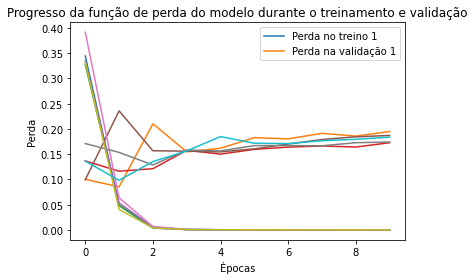

In [ ]:
plt.plot(history[0].history['loss'])
plt.plot(history[0].history['val_loss'])
plt.plot(history[1].history['loss'])
plt.plot(history[1].history['val_loss'])
plt.plot(history[2].history['loss'])
plt.plot(history[2].history['val_loss'])
plt.plot(history[3].history['loss'])
plt.plot(history[3].history['val_loss'])
plt.plot(history[4].history['loss'])
plt.plot(history[4].history['val_loss'])
plt.title('Progresso da função de perda do modelo durante o treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend(['Perda no treino 1', 'Perda na validação 1'])

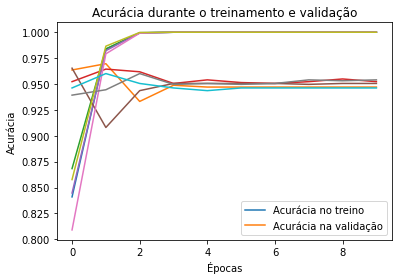

In [ ]:
plt.plot(history[0].history['accuracy'])
plt.plot(history[0].history['val_accuracy'])
plt.plot(history[1].history['accuracy'])
plt.plot(history[1].history['val_accuracy'])
plt.plot(history[2].history['accuracy'])
plt.plot(history[2].history['val_accuracy'])
plt.plot(history[3].history['accuracy'])
plt.plot(history[3].history['val_accuracy'])
plt.plot(history[4].history['accuracy'])
plt.plot(history[4].history['val_accuracy'])
plt.title('Acurácia durante o treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend(['Acurácia no treino', 'Acurácia na validação'])

In [ ]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(classes[indice_teste], previsoes, pos_label=2)
metrics.auc(fpr, tpr)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


nan

Text(0.5, 1.0, 'Matriz de confusão do classificador')

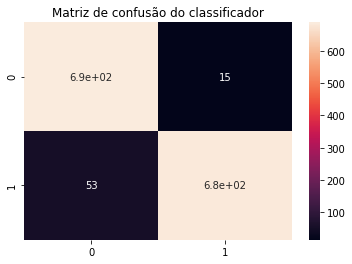

In [ ]:
sns.heatmap(matrizes[0], annot=True)
plt.title('Matriz de confusão do classificador')

#Novas Previsões

In [ ]:
#Remove caracteres especiais

def clean_text(text):
  text = BeautifulSoup(text, 'lxml').get_text()
  text = re.sub(r"@[A-Za-z0-9]+", ' ', text)
  text = re.sub(r"https?://[A-Za-z0-9./]+", ' ', text)
  text = re.sub(r"[^a-zA-Z.!?]", ' ', text)
  text = re.sub(r" +", ' ', text)
  return text

In [ ]:
#remove Stopwords

!python -m spacy download pt
nlp = sp.load('pt')
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('portuguese')

def clean_sw(text):
  text = text.lower()
  document = nlp(text)

  words = []
  for token in document:
    words.append(token.text)

  words = [word for word in words if word not in stopwords and word not in string.punctuation]
  words = ' '.join([str(element) for element in words])

  return text

✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/pt_core_news_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/pt
You can now load the model via spacy.load('pt')
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
text = 'Tristemente, como alguem pode votar em boulos. Joice merecia mais votos que ele outros no ranking. Isso se não teve fraude a eleicao em sp esta congelada em'
text = clean_text(clean_sw(text))
print(text)
text = tokenizer.encode(text)

tristemente como alguem pode votar em boulos. joice merecia mais votos que ele outros no ranking. isso se n o teve fraude a eleicao em sp esta congelada em


In [ ]:
pred= Dcnn(np.array([text]), training=False).numpy()
pred = (pred >0.5)
print(pred)

[[ True]]
